Table of Content
==============
- Libraries
- Environment Settings
- Read Datasets
- Dataset Helpers
- Clean Datasets
    1. Films
    2. Directors
    3. Awards
    4. Languages
    5. Countries
    6. Ratings
    7. Actors
    8. Writers
    9. Genres
- Save Dataset
- Datasets Results Overview

## Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from pprint import pprint

/home/carlos/.local/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Environment Settings

In [2]:
## Do not show warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['figure.figsize'] = (20,14)

## Set Dataframes table settings - Usefull to see non-truncated tables
pd.set_option('display.max_columns', 50)  # or 1000
pd.set_option('display.max_rows', 500)  # or 1000
# pd.set_option('display.max_colwidth', -1)  # or 199

## Read Datasets

In [3]:
films_df = pd.read_csv('original_datasets/Movie_Movies.csv')
ratings_df = pd.read_csv('original_datasets/Movie_AdditionalRating.csv')
genres_df = pd.read_csv('original_datasets/Movie_Genres.csv')
actors_df = pd.read_csv('original_datasets/Movie_Actors.csv')
writers_df = pd.read_csv('original_datasets/Movie_Writer.csv')

## Dataset Helpers

In [4]:
from typing import List, Dict
from pandas import DataFrame

class SeriesHelper:
    @classmethod
    def report_on_column(cls, col, bar=False):
        counts = col.value_counts()
        row_qty = len(col)
        print('NAME\tQTY(#)\tPERCENTAGE(%)')
        print('-------------------------------------')
        for name, qty in counts.items():
            percentage = round((qty / row_qty) * 100, 2)
            print(f'{name}\t\t{qty}\t{percentage}')

        if bar:
            col.value_counts().plot.bar()
            
    @classmethod
    def categorize_column(cls, col):
        col = col.astype('category')
        for category in col.cat.categories:
            print(category)
            

class DataframeHelper:
    ROW_QTY = 10
    GREEN_HEX =  '#58f00b' # available (not missing)
    RED_HEX = '#ff0000' # missing
    
    @classmethod
    def get_overview(cls, dataframe, dataframe_name='no dataframe name given!'):
        row_qty, col_qty = dataframe.shape
        print('#################')
        print(f'###  {dataframe_name}  ###', end='\n\n')
        print(f'Row quantity:  {row_qty}')
        print(f'Col quantity:  {col_qty}')
        print(f'Col names:  {dataframe.columns.values}')
        print('###')
        print(f'Types:  {dataframe.dtypes}', end='\n\n\n\n')
    
    @classmethod
    def get_report(cls, dataframe, dataframe_name, heatmap=True, hist=True):
        
        print(f'#######################################')
        print(f'######  {dataframe_name.upper()} DATASET OVERVIEW  ######', end='\n\n\n')
        print(f'###  Dataset overview - first {cls.ROW_QTY} lines  ###', end='\n\n')
        print(dataframe.head(cls.ROW_QTY))
        
        cls.get_missing_report(dataframe)
        
        if heatmap:
            cls.get_heatmap_missing_report(dataframe)
            print(f'\n\n\n ###  Missing Data Heatmap Report  ###', end='\n')
        if hist:
            cls.get_histogram_missing_report(dataframe)
    
    @classmethod
    def get_missing_report(cls, dataframe):
        import locale
        locale.setlocale(locale.LC_ALL, '')  # Use '' for auto, or force e.g. to 'en_US.UTF-8'

        total_rows, total_cols = dataframe.shape

        print(f'\n\n\n###########  Dataframe Report  ###########', end='\n\n')
        print(f'Total rows: {total_rows:n}')
        print(f'Total cols: {total_cols:n}')
        print(f'-----------------------------------------------------------------------------------------')
        print(f'Column\t\tAvailable(#)\tMissing(#)\tAvailable(%)\tMissing(%)\tRow Type')
        print(f'-----------------------------------------------------------------------------------------')

        for col in dataframe.columns:  
            bool_series  = dataframe[col].isnull()
            missing_perc = round(np.mean(bool_series) * 100, 3)
            available_perc = round(100 - missing_perc, 3)
            missing_rows = bool_series.sum()
            available_rows = dataframe[col].count()
            row_dtype = dataframe[col].dtype

            # to print with tabs and keep distance with {col}, i am cutting it until 8 characters and {number:n}
            # is to set the local number separation like 1000 would be in germany 1.000 or US 1,000
            print(f'{col[:7]}\t\t{available_rows:n}\t\t{missing_rows:n}\t\t{available_perc}%\t\t{missing_perc}%\t\t{row_dtype}')

    @classmethod
    def get_heatmap_missing_report(cls, dataframe):
        sns.heatmap(
            dataframe[dataframe.columns].isnull(),
            cmap=sns.color_palette([cls.GREEN_HEX, cls.RED_HEX])
        )
    
    @classmethod
    def get_histogram_missing_report(cls, dataframe):
        # make a copy since it will be modified
        dataframe = dataframe.copy(deep=True)
        for col in dataframe.columns:
            missing_bools = dataframe[col].isnull()
            missing_qty = np.sum(missing_bools)

            if missing_qty > 0:  
                # print(f'created missing indicator for: {col}')
                dataframe[f'{col}_ismissing'] = missing_bools
            

        # then based on the indicator, plot the histogram of missing values
        ismissing_cols = [col for col in dataframe.columns if 'ismissing' in col]
        dataframe['missing_qty'] = dataframe[ismissing_cols].sum(axis=1)

        (dataframe['missing_qty']
         .value_counts()
         .reset_index()
         .sort_values(by='index')
         .plot.bar(x='index', y='missing_qty'))
        
        
        
class StringCleaner:
    
    @classmethod
    def basic_string_housekeeping(cls, value):
        if cls.is_string(value):
            value = cls.strip_whitespaces(value)
            value = cls.lower_string(value)
            return value
        
    @classmethod
    def is_string(cls, value):
        if not isinstance(value, str):
            return False
        return True
    
    @classmethod
    def is_string_procesable(cls, value):
        """np.nan is a float type, so check before treating it as a string"""
        if isinstance(value, str) and not (value != value):   
            return True
        return False

    @classmethod
    def strip_whitespaces(cls, value: str) -> str:
        if not cls.is_string(value):
            raise Exception(f'Not a string: {str(value)}')
        return value.strip()

    @classmethod
    def lower_string(cls, value: str) -> str:
        if not cls.is_string(value):
            raise Exception(f'Not a string: {str(value)}')
        return value.lower()
    

class DataFrameCleaner:
    
    UNWANTED_COLS = ['Unnamed: 0', ]
    
    @classmethod
    def basic_dataframe_housekeeping(
            cls,
            dataframe: DataFrame,
            unwanted: List[str]=None,
            names: Dict[str, str]=None,
            order: List[str]=None,
            unwanted_duplicates: List[str]=None,
            row_drop: List[str]=None,
    ) -> DataFrame:
        
        df = dataframe.copy(deep=True)
        
        if unwanted:
            unwanted += cls.UNWANTED_COLS
            df = cls.delete_unwanted_columns(df, unwanted)
        else:
            df = cls.delete_unwanted_columns(df, cls.UNWANTED_COLS)
        if names:
            df = cls.rename_columns(df, names)
        if order:
            df = cls.order_columns(df, order)
        if unwanted_duplicates:
            df = df.drop_duplicates(subset=unwanted_duplicates)
        if row_drop:
            df = df.dropna(subset=row_drop, axis='columns')
        
        return df
            
    @classmethod
    def delete_unwanted_columns(cls, df, unwanted: List):
        for not_wanted in unwanted:
            if not_wanted in df.columns.to_list():
                del df[not_wanted]
        return df
                
    @classmethod
    def rename_columns(cls, df, names: Dict):
        return df.rename(columns=names)
    
    @classmethod
    def order_columns(cls, df, order: List):
        return df[order]
    
    
class ExtractDataset:
    @classmethod
    def extract_column_from_dataset(
        cls,
        dataframe: DataFrame,
        on: str,  # key id to keep
        column: str,  # column to explode
        # used to split(explode) the string in the cell if is a list of string
        # e.g "Germany, Venezuela" where "," or ", " is the delimiter
        delimiter: str=None,
        dropna: str=False  # if you want to drop the null values after exploding the column
    ):
        df = dataframe[[on, column]]  # just keep wanted columns
        if delimiter:
            df[column] = df[column].str.split(delimiter)  # make a list of value found in the string in each cell
        
        df = df.explode(column)  # explode each value in the list and make a new dataframe with just for new column
        if dropna:
            condition = df[column].notnull()
            df = df[condition]  # drop the empty rows in the new column
        return df

## Clean datasets

### 1. Films
#### Cleaning process

In [5]:
class FilmCleaner:
    ###  Year column cleaning  ###
    @classmethod
    def clean_year_column(cls, value):
        value = cls.remove_range_date(value)
        return value

    @classmethod
    def remove_range_date(clsl, value):
        """Values here are series and not movies. We will treat them as from year released"""
        if isinstance(value, str) and '–' in value:
            return value.split('–')[0]
        return value


    ###  Runtime column cleaning  ###
    ## Example formats for testings - taken from the movies dataset "Runtime" column
    format1 = '1 h 10 min' # 70
    format7 = '2 h 5 min'
    format2 = '14 h '       # 840
    format3 = '15 h 40 mi' # 940

    format4 = '1 min'      # 1
    format5 = '1,000 min'  # 1000
    format6 = '14,400 min' # 14400
    formats = [format1,format2,format3,format4,format5,format6,format7,]

    ## cleaning functions
    @classmethod
    def clean_runtime_column(cls, value):
        value = cls.format_runtime_with_hours_in_str(value)
        value = cls.format_runtime_with_mins_in_str(value)
        return value

    @classmethod
    def format_runtime_with_hours_in_str(cls, value):
        """Grab hours and then minutes and sum them and return total of seconds"""

        # if value==np.nan return it untouched
        if value != value or None or '':
            return np.nan

        runtime = 0
        if isinstance(value, str) and 'h' in value:
            hours, minutes = [value.strip() for value in value.split('h')]
            runtime += int(hours) * 60 * 60
            if minutes and 'min' or 'mi' in minutes:
                minutes = ''.join(char for char in minutes if char.isdigit())
                seconds = float(minutes) * 60
                runtime += seconds
            return str(runtime)
        return value
    
    @classmethod
    def format_runtime_with_mins_in_str(cls, value):
        """Grab the string with only minutes and erase ',' if """

        # if value==np.nan return it untouched
        if value != value or None or '':
            return np.nan

        if isinstance(value, str) and 'min' in value:
            value = value.split('min')[0].strip()
            minutes = value.replace(',', '')
            seconds = float(minutes) * 60
            return str(seconds)
        return value

#######################################
######  FILMS DATASET OVERVIEW  ######


###  Dataset overview - first 10 lines  ###

     imdb_id                                              title year_released  \
0  tt2268369                                      Baby's Breath          2012   
1  tt1560760                                       Winter Trees          2008   
2  tt0016750                                  The Crown of Lies          1926   
3  tt3405286                                             A Gift          2013   
4  tt3816698                                            Journey          2014   
5  tt3645730                                    In His Own Home          2014   
6  tt1837501                                          After War          2009   
7  tt0328410                            Sh! Don't Wake the Baby          1915   
8  tt0366512                               Three Shady Siblings          1966   
9  tt1006835  Beyond Batman: Visualizing Gotham - The Produc... 

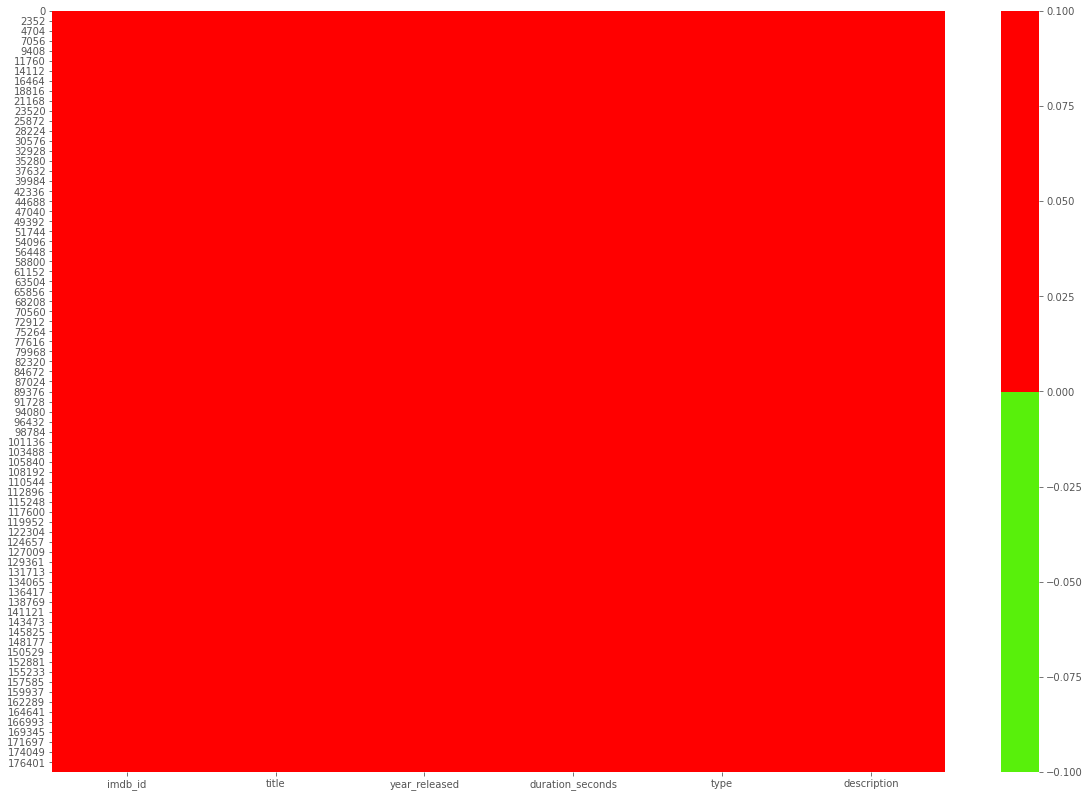

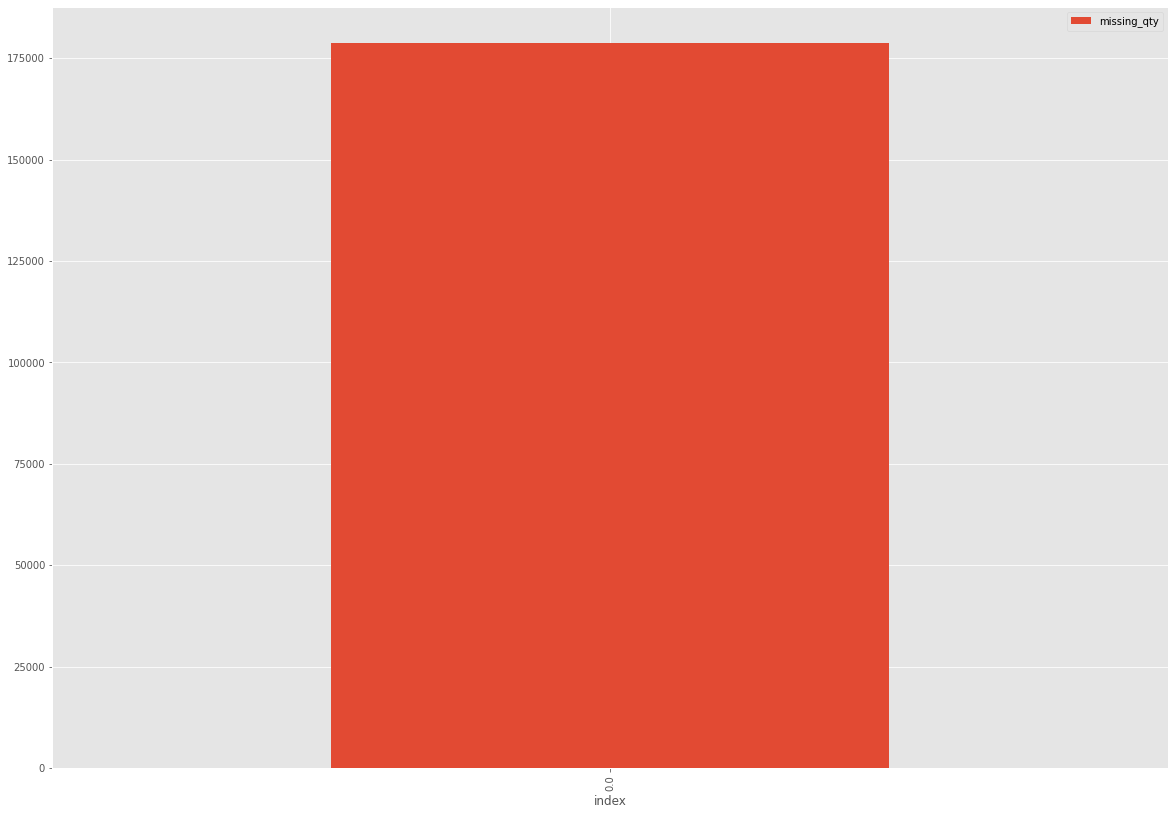

In [6]:
films = films_df.copy() # Do not mess the original dataframe



#########################################################################################
### Drop the colums that will be abstracted to its own dataset of database table
### Drop columns that are missing data missing
films_drop_cols_abstracted = [
    'Country',
    'Director',
    'Language',
]

films_drop_cols_missing_data = [
    'Awards',      # 89.0% missing
    'DVD',         # 91.0% 
    'Poster',      # 73.0%
    'Production',  # 91.0%
    'Rated',       # 87.0%
    'Released',    # 35.0% - "Year" column can serve the same porpuse and 0% is missing  
    'Website',     # 96.0%
    'imdbRating',  # 65.0%
    'imdbVotes',   # 65.0%
]

films_drop_cols = films_drop_cols_abstracted + films_drop_cols_missing_data
films.drop(columns=films_drop_cols, inplace=True)

#########################################################################################
### Rename columns
new_names = {
    'Title':'title',
    'Type':'type',
    'Year':'year_released',
    'imdbID':'imdb_id',
    'Plot':'description',
    'Runtime':'duration_seconds',
}

films.rename(columns=new_names, inplace=True)

#########################################################################################
### Reordering columns in dataframe
col_order = [
    'imdb_id',
    'title',
    'year_released',
    'duration_seconds', 
    'type',
    'description',        
]



#########################################################################################
### Droping garbage data
# Erased 1 record
films.dropna(
#             thresh=4,       # how many null values must contain to erase the row or column-if not specified
#             axis='rows', # or 'columns' # if not specified runs both
            how='all',      # or "any"
            inplace=True,
        )

subset = [
#     'imdb_id',
    'title',
#     'year_released',
#     'duration_mins', 
#     'type',
#     'description'     
]
# NO duplicates found ['imdb_id, ']
films.drop_duplicates(
                    subset=subset,
                    ignore_index= True,
#                     inplace=True,
                )



### General Checks
# Some checks will explode sure as this is the main dataset and data is missing
# check_imdb_id_missing(films)
# check_empty_string(films)
# check_if_any_are_missing_or_nan(films)



###########################
### Clean column "Type"
###########################
# convert it into categories and check uniqueness if they need cleaninig
# films.Type = films.Type.astype('category')
# for _type in films.Type.cat.categories:
#     print(_type, type(_type))
    
# films.type = films.type.str.capitalize()  # capitalize the types



###########################
### Clean column "Type"
###########################
# convert it categories and check uniqueness if they need cleaninig
# films.type = movies.type.astype('category')
# for _type in movies.type.cat.categories:
#     print(_type, type(_type))
    
# films.description = films.description.str.replace("'",'')  # 



###########################
### Clean column "Year"
###########################
# convert it into categories and check uniqueness if they need cleaninig
# films.Year = films.Year.astype('category')
# for year in films.Year.cat.categories:
#     print(year, type(year))

# clean Year column, remove the date range (series) and treat them as movies from the year released
# and convert them to float to avoid int comparison when value is is np.nan








# make datetime objects for year only
films.year_released = films.year_released.apply(lambda value: FilmCleaner.clean_year_column(value))








# AQUI MOVIE
###########################
### Clean column "Runtime"
###########################
# convert it into categories and check uniqueness if they need cleaninig
# for time in films.Runtime:
#     print(time, type(time))


# values = {'Runtime': 999999999}
# movies.fillna(value=values)
# movies.Runtime = movies.Runtime.astype(str)

# films.Runtime = films.Runtime.astype('category')
# for time in films.Runtime.cat.categories:
#     print(time, type(time))


#########################################################################################
### LAMBDA CLEAN
films.duration_seconds = films.duration_seconds.apply(lambda value: FilmCleaner.clean_runtime_column(value))
## Check if cleaning worked out.
# we will ignore the seconds in the minutes. so the floating point will be removed saving it in the db
# films.Runtime = films.Runtime.astype('category')
# for time in films.Runtime.cat.categories:
#     print(time, type(time))


    
    
    
    

    
    




### make sure the dtypes are correct after final cleaning
### beware forcing whole colums as types can strings can make queries not see null values or np.nan
# films.imdb_id = films.imdb_id.astype(str)
# films.description = films.description.astype(str)
# films.title = films.title.astype(str)
# films.type = films.type.astype(str)
# films.duration_seconds = films.duration_seconds.astype('float64')
# films.year_released = films.year_released.astype('float64')

films = films[col_order]
# print(films.imdb_id.is_unique) # this could be the identifier or the index


# print(films.head(5))
# print('\n\n\n')
# print(films.info())

# Plot - 45.0%
# Runtime - 33.0%
# Title - 0.0%
# Type - 0.0%
# Year - 0.0%
# imdbID - 0.0%

### General Checks
# check_imdb_id_missing(films)
# check_empty_string(films)
# check_if_any_are_missing_or_nan(films)



# check_list = ['', None, 'null', np.nan, np.tan]
# [how_many_there_are(_in=films, what=value) for value in check_list]





####### filling nan values
# movies.imdb_id.fillna(value=, inplace=True)
films.title.fillna(value='_MISSING_', inplace=True)
films.year_released.fillna(value=-999, inplace=True)
films.duration_seconds.fillna(value=-999, inplace=True)
# films.type.fillna(value='_MISSING_', inplace=True)
films.description.fillna(value='_MISSING_', inplace=True)
# films.fillna(
#         value='',
#         inplace=True,
#     )

DataframeHelper.get_report(films, 'films')

### 2. Directors
#### Cleaning process

In [7]:
import re

class DirectorCleaner(StringCleaner):

    CO_DIRECTOR_TAG = '(co-director)'
    NICKNAME_DELIMITERS = ["'", '"']
    MATCH_RULE = r"{char}(.*?){char}"  # {char} will be replaced with the delimiter dynamically
    
    @classmethod
    def get_co_directors(cls, value):
        """get the director's name and remove its tag"""
        if cls.is_string_procesable(value) and cls.CO_DIRECTOR_TAG in value:
            print(f'### Found co-director: {value}')
            return cls.remove_co_director_tag(value)
        return np.nan
    
    @classmethod
    def remove_co_director_tag(cls, value):
        return value.replace(cls.CO_DIRECTOR_TAG, '')
    
    @classmethod
    def remove_co_directors(cls, value):
        if cls.is_string_procesable(value) and cls.CO_DIRECTOR_TAG in value:
            print(f'### Removed co-director: {value}')
            return np.nan
        return value
    
    @classmethod
    def get_nickname(cls, value):
        if not cls.is_okay_to_process_nickname(value):
            # if nothing is found, return value unmodified
            return np.nan
        
        delimiter = cls.get_nickname_delimiter(value)
        return cls.extract_nickname(value, delimiter)
    
    @classmethod
    def remove_nickname(cls, value):
        if not cls.is_okay_to_process_nickname(value):
            # if nothing is found, return value unmodified
            return value
        
        delimiter = cls.get_nickname_delimiter(value)
        nickname = cls.extract_nickname(value, delimiter)
        return cls.clean_nickname_from_name(value, nickname, delimiter)
    
    @classmethod
    def is_okay_to_process_nickname(cls, value):
        if cls.is_string_procesable(value):
            delimiter = cls.get_nickname_delimiter(value)
            if delimiter:
                ocurrence = cls.ocurrence_of_character(delimiter, value)
                if ocurrence == 2:
                    return True
                else:
                    print(f'### Ocurrence of delimiter is: {ocurrence} from string {value}')
        return False
    
    @classmethod
    def clean_nickname_from_name(cls, value, nickname, delimiter):
        value = value.replace(nickname, '')
        value = value.replace(delimiter, '')
        return value
            
    @classmethod
    def get_nickname_delimiter(cls, value):
        found = [char for char in cls.NICKNAME_DELIMITERS if char in value]
        if not found:
            return None
        elif len(found) == 1:
            return found[0]
        elif len(found) > 1:
            raise Exception(f'### Found more than 1 delimiter {found} in string: {value}')
    
    @classmethod
    def ocurrence_of_character(cls, char, value):
        return value.count(char)
    
    @classmethod
    def extract_nickname(cls, value, delimiter):
        match = cls.MATCH_RULE.replace('{char}', delimiter)
        return re.findall(match, value)[0]

# class DirectorsCleanerExtra:
#     @classmethod
#     def move_co_directors_to_new_column(cls, row):
#         """This method takes a whole row from dataframe"""
#         row['movie_id'] = row['movie_id'] # do not touch this

#         name = row['director_name']
#         if name and not (name != name) and '(co-director)' in name:
#             # if is a co-director: erase it from directors column and move it to its own col
#             row['director_name'], row['co_director_name'] = np.nan, name
#         else:
#             # when not, leave everything the same and add None value to co-director column
#             row['director_name'], row['co_director_name'] = name, np.nan
#         return row

In [8]:
directors = films_df.copy()# Do not mess the original dataframe

directors = ExtractDataset.extract_column_from_dataset(
    directors,
    on='imdbID',
    column='Director',
    delimiter=', ',
    dropna=False,
)

    
### New columns' names
new_names = {
    'Director':'director_name',
    'imdbID':'movie_id',
}
### Create new columns
new_cols = ['director_nickname', 'co_director_name', 'co_director_nickname']
for col in new_cols:
    directors[col] = np.nan
    
col_order = ['movie_id', 'director_name', 'director_nickname', 'co_director_name', 'co_director_nickname']  ### Reordering columns in dataframe

directors = DataFrameCleaner.basic_dataframe_housekeeping(
    directors,
    unwanted=None,
    names=new_names,
    order=col_order,
    unwanted_duplicates=['movie_id', 'director_name'],
)
# DataframeHelper.get_report(directors, 'Directors', heatmap=True, hist=True)

### Clean column "movie_id" and "name"
directors.movie_id = directors.movie_id.apply(lambda value: StringCleaner.basic_string_housekeeping(value))

directors.director_name = directors.director_name.apply(lambda value: StringCleaner.basic_string_housekeeping(value))
# directors = directors.apply(lambda row: DirectorsCleaner.move_co_directors_to_new_column(row), axis='columns')
'''
(co-director)= to co_director
'nico'= to nickname
"nico"= to nickname
'''

# step processing

# Checks if there are co-directors in director_name and copies it to its own co_dicrector_name
directors.co_director_name = directors.director_name.apply(lambda value: DirectorCleaner.get_co_directors(value))

# Removes the a co-director from directors_name
directors.director_name = directors.director_name.apply(lambda value: DirectorCleaner.remove_co_directors(value))


# Checks if director or co_directors have a nick name and copies it to its own dicrector_nickname and co_dicrector_nickname
directors.director_nickname = directors.director_name.apply(lambda value: DirectorCleaner.get_nickname(value))
directors.co_director_nickname = directors.co_director_name.apply(lambda value: DirectorCleaner.get_nickname(value))

# Removes nicknames from directors and co directors leaving the fullname
directors.director_name = directors.director_name.apply(lambda value: DirectorCleaner.remove_nickname(value))
directors.co_director_name = directors.co_director_name.apply(lambda value: DirectorCleaner.remove_nickname(value))


print(directors.shape)

directors = DataFrameCleaner.basic_dataframe_housekeeping(
    directors,
    unwanted_duplicates=['movie_id', 'director_name', 'director_nickname', 'co_director_name', 'co_director_nickname'],
#     row_drop=['movie_id', 'director_name',],
)
print(directors.shape)
### Make sure the dtype are consistent
# directors.movie_id = directors.movie_id.astype(str)
# directors.director_name = directors.director_name.astype(str)
# directors.co_director_name = directors.co_director_name.astype(str)
# directors.director_nickname = directors.director_nickname.astype(str)
# directors.co_director_nickname = directors.co_director_nickname.astype(str)


### Check the final result
# print('\n')
# print(directors.info(), end='\n\n\n\n\n')
# print(directors.head(200))
directors.reset_index(drop=True, inplace=True)
print(directors.shape)
directors = directors.dropna(subset=['movie_id', 'director_name','co_director_name'], thresh=2, axis='rows')
# directors = directors.dropna(how='all', axis='rows')
# print(directors.shape)
# directors.head(25)



# DataframeHelper.get_report(directors, 'Directors', heatmap=True, hist=True)
# SeriesHelper.categorize_column(directors.name)

print(len(directors[directors['director_name'] == 'None']))
print(len(directors[directors['director_name'] == 'none']))
print(len(directors[directors['director_name'] == 'null']))
print(len(directors[directors['director_name'] == None]))
print(directors.shape)
# directors = directors[directors['director_name'] != 'None']
print(directors.shape)

### Found co-director: lin lin(co-director)
### Found co-director: bennett viseltear(co-director)
### Found co-director: douglas weiss(co-director)
### Found co-director: gerardo ardoy(co-director)
### Found co-director: miguel ledesma(co-director)
### Found co-director: felipe medina(co-director)
### Found co-director: maryna gorbach(co-director)
### Found co-director: geoff callan(co-director)
### Found co-director: ruth carranza(co-director)
### Found co-director: sanping han(co-director)
### Found co-director: jianxin huang(co-director)
### Found co-director: doug scheiber(co-director)
### Found co-director: mariachiara pernisa(co-director)
### Found co-director: robert k. weiss(co-director)
### Found co-director: derick hearit(co-director)
### Found co-director: scott allen pickford(co-director)
### Found co-director: ricardo pantoja(co-director)
### Found co-director: brian allan stewart(co-director)
### Found co-director: hawley pratt(co-director)
### Found co-director: johnny b

### Removed co-director: brent nemetz(co-director)
### Removed co-director: merieme addou(co-director)
### Removed co-director: meosha bean(co-director)
### Removed co-director: ash brannon(co-director)
### Removed co-director: lee unkrich(co-director)
### Removed co-director: marc clebanoff(co-director)
### Removed co-director: jan oliver lucks(co-director)
### Removed co-director: julia parnell(co-director)
### Removed co-director: cristina pippa(co-director)
### Removed co-director: kevin dunn(co-director)
### Removed co-director: jeremy lange(co-director)
### Removed co-director: walter e. campbell(co-director)
### Removed co-director: martin m. clark(co-director)
### Removed co-director: gad aisen(co-director)
### Removed co-director: andrew leavold(co-director)
### Removed co-director: daniel palisa(co-director)
### Removed co-director: frank nissen(co-director)
### Removed co-director: kevin clark(co-director)
### Removed co-director: manzie jones(co-director)
### Removed co-dir

### Ocurrence of delimiter is: 1 from string patrick d'hoostelaere
### Ocurrence of delimiter is: 1 from string shin'ya tsukamoto
### Ocurrence of delimiter is: 1 from string casey o'brian
### Ocurrence of delimiter is: 1 from string peter o'brian
### Ocurrence of delimiter is: 1 from string shin'ya tsukamoto
### Ocurrence of delimiter is: 1 from string declan o'dwyer
### Ocurrence of delimiter is: 1 from string antoni d'ocon
### Ocurrence of delimiter is: 1 from string eduard huis in 't veld
### Ocurrence of delimiter is: 1 from string sally d'angelo
### Ocurrence of delimiter is: 1 from string dan o'connell
### Ocurrence of delimiter is: 1 from string henri d'elba
### Ocurrence of delimiter is: 1 from string danny o'bryen
### Ocurrence of delimiter is: 1 from string deirdre o'connor
### Ocurrence of delimiter is: 1 from string josef d'bache-kane
### Ocurrence of delimiter is: 1 from string frank o'connor
### Ocurrence of delimiter is: 1 from string joe d'amato
### Ocurrence of delimi

### Ocurrence of delimiter is: 1 from string eli o'donnell
### Ocurrence of delimiter is: 1 from string peter o'neill
### Ocurrence of delimiter is: 1 from string darion d'anjou
### Ocurrence of delimiter is: 1 from string philip mc'nroe rakesh
### Ocurrence of delimiter is: 1 from string joe d'amato
### Ocurrence of delimiter is: 1 from string ton'e brown
### Ocurrence of delimiter is: 1 from string dena o'dell
### Ocurrence of delimiter is: 1 from string jorden d'onofrio
### Ocurrence of delimiter is: 1 from string colin o'rourke
### Ocurrence of delimiter is: 1 from string dylan o'neil
### Ocurrence of delimiter is: 1 from string karen o'toole
### Ocurrence of delimiter is: 1 from string eoin o'shea
### Ocurrence of delimiter is: 1 from string joe d'amato
### Ocurrence of delimiter is: 1 from string deirdre o'neill
### Ocurrence of delimiter is: 1 from string john b. o'brien
### Ocurrence of delimiter is: 1 from string rob o'neill
### Ocurrence of delimiter is: 1 from string anthony

### Ocurrence of delimiter is: 1 from string willis h. o'brien
### Ocurrence of delimiter is: 1 from string sa'adat rahimzadeh
### Ocurrence of delimiter is: 1 from string dee koppang o'leary
### Ocurrence of delimiter is: 1 from string geoff d'eon
### Ocurrence of delimiter is: 1 from string arge o'neal
### Ocurrence of delimiter is: 1 from string kevin o'bryan
### Ocurrence of delimiter is: 1 from string maria o'bryan
### Ocurrence of delimiter is: 1 from string eugene o'connor
### Ocurrence of delimiter is: 1 from string taylor ri'chard
### Ocurrence of delimiter is: 1 from string ruairi o'brien
### Ocurrence of delimiter is: 1 from string damien o'neill
### Ocurrence of delimiter is: 1 from string robert vincent o'neill
### Ocurrence of delimiter is: 1 from string ton'e brown
### Ocurrence of delimiter is: 1 from string alyssa d'adamo
### Ocurrence of delimiter is: 1 from string kevin o'regan
### Ocurrence of delimiter is: 1 from string john b. o'brien
### Ocurrence of delimiter is

(195511, 5)
(195508, 5)
(195508, 5)
0
0
0
0
(168174, 5)
(168174, 5)


### 3. Awards
#### Cleaning process

In [9]:
'''
Examples of awards for cleaning:
    - 4 nominations.
    - 4 wins & 1 nomination.
    
    - Nominated for 1 BAFTA Film Award. Another 1 nomination.
    - Nominated for 1 BAFTA Film Award. Another 1 win & 2 nominations.
    - nominated for 2 bafta film awards. another 1 nomination.
    
    - Nominated for 1 Golden Globe. Another 1 nomination.
    - Nominated for 1 Golden Globe. Another 2 wins & 9 nominations.
    - Nominated for 6 golden globes. another 3 nominations.
    
    - Nominated for 1 oscar. another 9 wins & 9 nominations.
    - Nominated for 10 Oscars. Another 70 wins & 208 nominations.
    
    - Nominated for 1 Primetime Emmy. Another 1 win & 1 nomination.
    - Nominated for 5 Primetime Emmys. another 1 win & 1 nomination.
    
    - Won 1 BAFTA Film Award. Another 11 wins & 30 nominations.
    - won 2 bafta film awards. another 4 nominations.
    
    - Won 1 Golden Globe. Another 9 wins & 8 nominations.
    - won 2 golden globes. another 1 win & 6 nominations
    
    - Won 9 Oscars. Another 53 wins & 75 nominations.
    - won 10 oscars. another 18 wins & 11 nominations.
'''

class AwardCleaner(StringCleaner):
    AWARD_NAMES = ['oscar', 'golden globe', 'primetime emmy', 'bafta']
    UNKNOWN_AWARD = 'unknown'
    
    
    KNOWN_AWARD_KEYWORD = 'won'
    KNOWN_NOMINATION_KEYWORD = 'nominated'
    
    KNOWN_AWARD_DELIMITER = '. '
    
    UNKNOWN_AWARD_KEYWORD = 'win'
    UNKNOWN_NOMITATION_KEYWORD = 'nomination'
    
    UNKNOWN_AWARD_AND_NOMINATION_DELIMITER = ' & '
    
    @classmethod
    def extract_awards_and_copy_them_into_their_own_feature(cls, row: pd.Series) -> pd.Series:  
        """This method takes a whole row from dataframe"""
        
        row['movie_id'] = row['movie_id'] # do not touch this
        row['awards_unclean'] = row['awards_unclean'] # do not touch this        

        unclean_award_string = row['awards_unclean']
        awards = cls.breakdown_awards(unclean_award_string)
        
        for k, v in awards.items():
            row[k] = v
        
        return row        
    
    @classmethod
    def breakdown_awards(cls, value: str) -> Dict[str, str]:
        """
        Receives a string containing all details about awards and breaks it down into catorgies
        such as award name and award quantity.
        """
        
        awards = {
            'award_name': np.nan,
            'award_qty': np.nan,
            'extra_award_name': np.nan,
            'extra_award_qty': np.nan,
            'nomination_name': np.nan,
            'nomination_qty': np.nan,
            'extra_nomination_name': np.nan,
            'extra_nomination_qty': np.nan,
        }
        
        # Main win award 
        if cls.KNOWN_AWARD_KEYWORD in value:
            main_award, unknown = value.split(cls.KNOWN_AWARD_DELIMITER)

            award_name, award_qty = cls.get_name_and_qty(main_award)
            awards.update({
                'award_name': award_name,
                'award_qty': award_qty,
            })
            unknown_awards = cls.get_unknown_awards_and_nominations(unknown)
            awards.update(unknown_awards)
            return awards    
        
        # Main nomination    
        elif cls.KNOWN_NOMINATION_KEYWORD in value:
            main_nomination, unknown = value.split(cls.KNOWN_AWARD_DELIMITER)
            
            award_nomination_name, award_nomination_qty = cls.get_name_and_qty(main_nomination)
            awards.update({
                'nomination_name': award_nomination_name,
                'nomination_qty': award_nomination_qty,
            })
            unknown_awards = cls.get_unknown_awards_and_nominations(unknown)
            awards.update(unknown_awards)
            return awards
        
        # Unknow wins or nominations
        else:
            unknown_awards = cls.get_unknown_awards_and_nominations(value)
            awards.update(unknown_awards)
            return awards
        

    @classmethod
    def get_unknown_awards_and_nominations(cls, value: str) -> Dict[str, str]:
        unknown_awards = {}
        #extra awards and nominations
        if cls.UNKNOWN_AWARD_AND_NOMINATION_DELIMITER in value:
            wins, nominations = value.split(cls.UNKNOWN_AWARD_AND_NOMINATION_DELIMITER)
            extra_award_name, extra_award_qty = cls.get_name_and_qty(wins)
            extra_award_nomination_name, extra_award_nomination_qty = cls.get_name_and_qty(nominations)
            unknown_awards.update({
                'extra_award_name': extra_award_name,
                'extra_award_qty': extra_award_qty,
                'extra_nomination_name': extra_award_nomination_name,
                'extra_nomination_qty': extra_award_nomination_qty,
            })
            return unknown_awards
            
        elif cls.UNKNOWN_AWARD_KEYWORD in value:
            #wins
            extra_award_name, extra_award_qty = cls.get_name_and_qty(value)
            unknown_awards.update({
                'extra_award_name': extra_award_name,
                'extra_award_qty': extra_award_qty,
            })
            return unknown_awards
        
        elif cls.UNKNOWN_NOMITATION_KEYWORD in value:
            # nominations
            extra_award_nomination_name, extra_award_nomination_qty = cls.get_name_and_qty(value)
            unknown_awards.update({
                'extra_nomination_name': extra_award_nomination_name,
                'extra_nomination_qty': extra_award_nomination_qty,
            })
            return unknown_awards

    @classmethod
    def get_name_and_qty(cls, value):
        name = cls.get_award_name(value)
        qty = cls.get_qty_from_sentence(value)
        return name, qty
    
    @classmethod
    def get_award_name(cls, value):
        known_award = [name for name in cls.AWARD_NAMES if name in value]
        if known_award:
            return known_award[0]
        return cls.UNKNOWN_AWARD
    
    @classmethod
    def get_qty_from_sentence(cls, value):
        return [int(s) for s in value.split() if s.isdigit()][0]


In [10]:
awards = films_df.copy()# Do not mess the original dataframe
# awards.info()

print(awards.shape)
awards = ExtractDataset.extract_column_from_dataset(
    awards,
    on='imdbID',
    column='Awards',
#     delimiter=', ',
    dropna=False,
)
print(awards.shape)

    
### New columns' names
new_names = {
    'Awards':'awards_unclean',
    'imdbID':'movie_id',
}
### Create new columns
new_cols = ['award_name', 'award_qty',
            'extra_award_name', 'extra_award_qty',
            'nomination_name', 'nomination_qty',
            'extra_nomination_name', 'extra_nomination_qty']
for col in new_cols:
    awards[col] = np.nan
    
col_order = ['movie_id', 'oscars', '10', 'unknown', '100', 'unknow', '27']  ### Reordering columns in dataframe
col_order = ['movie_id', 'awards_unclean'] + new_cols  ### Reordering columns in dataframe

awards = DataFrameCleaner.basic_dataframe_housekeeping(
    awards,
    unwanted=None,
    names=new_names,
    order=col_order,
    unwanted_duplicates=['movie_id', 'awards_unclean'],
)
awards = awards.dropna(subset=['movie_id', 'awards_unclean'], thresh=2, axis='rows')
# DataframeHelper.get_report(directors, 'Directors', heatmap=True, hist=True)

### Clean column "movie_id" and "name"
awards.movie_id = awards.movie_id.apply(lambda value: StringCleaner.basic_string_housekeeping(value))
awards.awards_unclean = awards.awards_unclean.apply(lambda value: StringCleaner.basic_string_housekeeping(value))

# This sends the whole row from the dataframe.
awards = awards.apply(lambda row: AwardCleaner.extract_awards_and_copy_them_into_their_own_feature(row), axis='columns')

# DataframeHelper.get_report(awards, 'awards', heatmap=True, hist=True)
# SeriesHelper.categorize_column(awards.awards_unclean)
# awards.head(200)
print(len(awards[awards['awards_unclean'] == 'None']))
print(len(awards[awards['awards_unclean'] == 'none']))
print(len(awards[awards['awards_unclean'] == 'null']))
print(len(awards[awards['awards_unclean'] == None]))
print(awards.shape)
awards = awards[awards['awards_unclean'] != 'None']
print(awards.shape)

(178687, 18)
(178687, 2)
0
0
0
0
(20340, 10)
(20340, 10)


### 4. Languages
#### Cleaning process

In [11]:
## Make languages column into its own dataset with a relationship on movie imdbID
languages = films_df.copy()
# print(len(languages))


### Clean column "Language"
# convert it into categories and check uniqueness if they need cleaninig
# languages.Language = languages.Language.astype('category')
# languages.Language.cat.categories


languages = languages[['Language', 'imdbID']]  # just keep wanted columns
print(f'\n\n### Before exloding columns Language: ROW QUANTITY: {len(languages)}  ###\n\n')
languages.Language = languages.Language.str.split(', ')  # make a list of Language for each movie
languages = languages.explode('Language')  # explode each Language in the list and make a new dataframe with just for countries
languages = languages[languages['Language'].notnull()]  # drop the empty rows (no languages)
print(f'\n\n### After exloding columns Language: ROW QUANTITY: {len(languages)}  ###\n\n')
# print(languages.head(10))



### General Checks
# check_movie_id_missing(languages)
# check_empty_string(languages)
# check_if_any_are_missing_or_nan(languages)


### Rename columns
new_names = {
    'Language':'language_name',
    'imdbID':'movie_id',
}

languages.rename(columns=new_names, inplace=True)

### Reordering columns in dataframe
col_order = [
    'movie_id',
    'language_name',
]

languages = languages[col_order]
# print(languages.imovie_id.is_unique) # if exploded, it should not be unique

# convert it again and check if categories were fixed or not
# languages['temp_name'] = languages.language_name.astype('category')
# print(f'Genre Qty: {len(languages.temp_name.cat.categories)}')
# print(languages.temp_name.cat.categories.values)
# del languages['temp_name']



### Make sure the dtype are consistent
languages.language_name = languages.language_name.astype(str)
languages.movie_id = languages.movie_id.astype(str)


### Check the final result
print('\n\n\n')
# print(languages.info(), end='\n\n\n\n\n')
# print(languages.head(10))

print(len(languages[languages['language_name'] == 'None']))
print(len(languages[languages['language_name'] == 'none']))
print(len(languages[languages['language_name'] == 'null']))
print(len(languages[languages['language_name'] == None]))
print(languages.shape)
languages = languages[languages['language_name'] != 'None']
print(languages.shape)
print(languages[languages['language_name'] == 'None'])




### Before exloding columns Language: ROW QUANTITY: 178687  ###




### After exloding columns Language: ROW QUANTITY: 165818  ###






170
0
0
0
(165818, 2)
(165648, 2)
Empty DataFrame
Columns: [movie_id, language_name]
Index: []


### 5. Countries
#### Cleaning process

In [12]:
countries = films_df.copy() # Do not mess the original dataframe

### New columns' names
new_names = {
    'Country':'country_name',
    'imdbID':'movie_id',
}
col_order = ['movie_id', 'country_name',] ### Reordering columns in dataframe

countries = DataFrameCleaner.basic_dataframe_housekeeping(
    countries,
    unwanted=None,
    names=new_names,
    order=col_order,
)

### Clean column "movie_id" and "name"
countries.movie_id = countries.movie_id.apply(lambda value: StringCleaner.basic_string_housekeeping(value))
countries.country_name = countries.country_name.apply(lambda value: StringCleaner.basic_string_housekeeping(value))

### Make sure the dtype are consistent
countries.country_name = countries.country_name.astype(str) 
countries.movie_id = countries.movie_id.astype(str)

### Check the final result
# print('\n')
# print(countries.info(), end='\n\n\n\n\n')
# print(countries.head(10))

print(len(countries[countries['country_name'] == 'None']))
print(len(countries[countries['country_name'] == 'none']))
print(len(countries[countries['country_name'] == 'null']))
print(len(countries[countries['country_name'] == None]))
print(countries.shape)
countries = countries[countries['country_name'] != 'None']
print(countries.shape)

12689
0
0
0
(178687, 2)
(165998, 2)


### 6. Ratings
#### Cleaning process

In [13]:
class RatingsCleaner(StringCleaner):
    
    @classmethod
    def clean_ratings_scores(cls, value):
        value = cls.basic_string_housekeeping(value)
        value = cls.clean_imdb_rating(value)
        value = cls.clean_rotten_rating(value)
        value = cls.clean_metacritic_rating(value)
        return value

    @classmethod
    def clean_imdb_rating(cls, value):
        if cls.is_string(value) and ('/' and '.' in value):
            # get the important part "6.9" of the rating "6.9/10"
            # and convert it to a value between 0-1
            return float(value.split('/')[0]) / 10
        # if its not imdb rating format return the value untouched
        return value
    
    @classmethod
    def clean_rotten_rating(cls, value):
        if cls.is_string(value) and ('%' in value):
            # get the important part "13" of the rating "13%"
             # and convert it to a value between 0-1
            return float(value.replace('%', '')) / 100
        # if its not rotten rating format return the value untouched
        return value
    
    @classmethod
    def clean_metacritic_rating(cls, value):
        if cls.is_string(value) and ('/' and not '.' in value):
            # get the important part "27" of the rating "27/100"
            # and convert it to a value between 0-1
            return float(value.split('/')[0]) / 100
        # if its not metacritic rating format return the value untouched
        return value

In [14]:
ratings = ratings_df.copy() # Do not mess the original dataframe

### New columns' names
new_names = {
    'RatingSource':'rating_source',
    'Rating':'rating_score',
    'imdbID':'movie_id',
}
col_order = ['movie_id', 'rating_score', 'rating_source',] ### Reordering columns in dataframe

ratings = DataFrameCleaner.basic_dataframe_housekeeping(
    ratings,
    unwanted=None,
    names=new_names,
    order=col_order,
)

### Clean column "movie_id" and "source"
ratings.movie_id = ratings.movie_id.apply(lambda value: StringCleaner.basic_string_housekeeping(value))
ratings.rating_source = ratings.rating_source.apply(lambda value: StringCleaner.basic_string_housekeeping(value))

### Clean column "score"
# there are 3 types or sources Ratings
# 6.9/10
# 13%
# 27/100
ratings.rating_score = ratings.rating_score.apply(lambda value: RatingsCleaner.clean_ratings_scores(value))


### Make sure the dtype are consistent
ratings.movie_id = ratings.movie_id.astype(str)
ratings.rating_score = ratings.rating_score.astype(np.float64)
ratings.rating_source = ratings.rating_source.astype(str)

### Check the final result
print('\n')
print(ratings.info(), end='\n\n\n\n\n')
print(ratings.head(10))
print('\n\n\n### Rating Score Description')
print(ratings.rating_score.describe())

print(len(ratings[ratings['rating_score'] == 'None']))
print(len(ratings[ratings['rating_score'] == 'none']))
print(len(ratings[ratings['rating_score'] == 'null']))
print(len(ratings[ratings['rating_score'] == None]))

print(len(ratings[ratings['rating_source'] == 'None']))
print(len(ratings[ratings['rating_source'] == 'none']))
print(len(ratings[ratings['rating_source'] == 'null']))
print(len(ratings[ratings['rating_source'] == None]))

print(len(ratings[ratings['movie_id'] == 'None']))
print(len(ratings[ratings['movie_id'] == 'none']))
print(len(ratings[ratings['movie_id'] == 'null']))
print(len(ratings[ratings['movie_id'] == None]))

print(ratings.shape)
# ratings = ratings[ratings['score'] != 'None']
print(ratings.shape)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       92016 non-null  object 
 1   rating_score   92016 non-null  float64
 2   rating_source  92016 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.1+ MB
None




    movie_id  rating_score            rating_source
0  tt1006835          0.69  internet movie database
1  tt2554714          0.24  internet movie database
2  tt1090670          0.63  internet movie database
3  tt1990255          0.55  internet movie database
4  tt0206367          0.50  internet movie database
5  tt0206367          0.15          rotten tomatoes
6  tt0206367          0.27               metacritic
7  tt0046287          0.76  internet movie database
8  tt0025597          0.68  internet movie database
9  tt0288410          0.72  internet movie database



### Rating Score Description
count

### 7. Actors
#### Cleaning process

In [15]:
actors = actors_df.copy() # Do not mess the original dataframe

### New columns' names
new_names = {
    'Actors':'actor_name',
    'imdbID':'movie_id',
}
col_order = ['movie_id', 'actor_name',] ### Reordering columns in dataframe

actors = DataFrameCleaner.basic_dataframe_housekeeping(
    actors,
    unwanted=None,
    names=new_names,
    order=col_order,
)

### Clean column "name" and "imdb_id"
actors.movie_id = actors.movie_id.apply(lambda value: StringCleaner.basic_string_housekeeping(value))
actors.actor_name = actors.actor_name.apply(lambda value: StringCleaner.basic_string_housekeeping(value))

### Make sure the dtype are consistent
actors.actor_name = actors.actor_name.astype(str)  # make sure all values in Year are "str" type or in pandas "object" type 
actors.movie_id = actors.movie_id.astype(str)


### Check the final result
print('\n\n\n')
print(actors.info(), end='\n\n\n\n\n')
print(actors.head(10)) 

print(len(actors[actors['actor_name'] == 'None']))
print(len(actors[actors['actor_name'] == 'none']))
print(len(actors[actors['actor_name'] == 'null']))
print(len(actors[actors['actor_name'] == None]))
print(actors.shape)
# actors = actors[actors['actor_name'] != 'None']
print(actors.shape)





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143869 entries, 0 to 143868
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   movie_id    143869 non-null  object
 1   actor_name  143869 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB
None




    movie_id          actor_name
0  tt2268369        cass barbera
1  tt0016750     charles a. post
2  tt3405286        samuel green
3  tt3816698        surin mendis
4  tt0328410           baby rube
5  tt0366512       jeung-nyeo ju
6  tt1006835   graham churchyard
7  tt3481238       sarah plummer
8  tt5861482  caroline mangosing
9  tt6415892      anton stephans
0
0
0
0
(143869, 2)
(143869, 2)


### 8. Writers
#### Cleaning process

In [16]:
writers = writers_df.copy() # Do not mess the original dataframe

### New columns' names
new_names = {
    'Person':'writer_name',
    'Responsibility':'writer_role',
    'imdbID':'movie_id',
}
col_order = ['movie_id', 'writer_name', 'writer_role',] ### Reordering columns in dataframe

writers = DataFrameCleaner.basic_dataframe_housekeeping(
    writers,
    unwanted=None,
    names=new_names,
    order=col_order,
)

### Clean column "name" and "imdb_id"
writers.movie_id = writers.movie_id.apply(lambda value: StringCleaner.basic_string_housekeeping(value))
writers.writer_name = writers.writer_name.apply(lambda value: StringCleaner.basic_string_housekeeping(value))
writers.writer_role = writers.writer_role.apply(lambda value: StringCleaner.basic_string_housekeeping(value))

### Make sure the dtype are consistent
writers.movie_id = writers.movie_id.astype(str)
writers.writer_name = writers.writer_name.astype(str)
writers.writer_role = writers.writer_role.astype(str)


### Check the final result
print('\n\n\n')
print(writers.info(), end='\n\n\n\n\n')
print(writers.head(10)) 





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66164 entries, 0 to 66163
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movie_id     66164 non-null  object
 1   writer_name  66164 non-null  object
 2   writer_role  66164 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB
None




    movie_id          writer_name writer_role
0  tt0016750         ernest vajda       story
1  tt0328410        ben f. wilson    scenario
2  tt0366512         sam-yuk yoon  screenplay
3  tt0206367    judy rothman rofé  screenplay
4  tt0206367           e.b. white        book
5  tt0046287  norman reilly raine       story
6  tt0046287         steve fisher  screenplay
7  tt0025597         franz schulz       story
8  tt0025597         billy wilder       story
9  tt1851002    andrew n. shearer       story


### 9. Genres
#### Cleaning process

In [17]:
genres = genres_df.copy() # Do not mess the original dataframe

### New columns' names
new_names = {
    'Genre':'genre_name',
    'imdbID':'movie_id',
}
col_order = ['movie_id', 'genre_name',] ### Reordering columns in dataframe

genres = DataFrameCleaner.basic_dataframe_housekeeping(
    genres,
    unwanted=None,
    names=new_names,
    order=col_order,
)

### Clean column "name" and "imdb_id"
genres.movie_id = genres.movie_id.apply(lambda value: StringCleaner.basic_string_housekeeping(value))
genres.genre_name = genres.genre_name.apply(lambda value: StringCleaner.basic_string_housekeeping(value))


### Make sure the dtype are consistent
genres.movie_id = genres.movie_id.astype(str)
genres.genre_name = genres.genre_name.astype(str)

### Check the final result
# convert it again and check if categories were fixed or not
genres['temp_name'] = genres.genre_name.astype('category')
print(f'Genre Qty: {len(genres.temp_name.cat.categories)}')
print(genres.temp_name.cat.categories.values)
del genres['temp_name']

print('\n\n\n')
print(genres.info(), end='\n\n\n\n\n')
print(genres.head(10))
print('\n\n\n###  Quantity of films group by genre name')
# print(SeriesHelper.report_on_column(genres.name, bar=True))
genres


print(len(genres[genres['genre_name'] == 'None']))
print(len(genres[genres['genre_name'] == 'none']))
print(len(genres[genres['genre_name'] == 'null']))
print(len(genres[genres['genre_name'] == None]))
print(genres.shape)
# genres = genres[genres['genre_name'] != 'None']
print(genres.shape)


Genre Qty: 28
['action' 'adult' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'fantasy' 'film-noir' 'game-show'
 'history' 'horror' 'music' 'musical' 'mystery' 'news' 'reality-tv'
 'romance' 'sci-fi' 'short' 'sport' 'talk-show' 'thriller' 'war' 'western']




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308565 entries, 0 to 308564
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   movie_id    308565 non-null  object
 1   genre_name  308565 non-null  object
dtypes: object(2)
memory usage: 4.7+ MB
None




    movie_id   genre_name
0  tt2268369        short
1  tt2268369        drama
2  tt1560760        short
3  tt1560760        drama
4  tt0016750        drama
5  tt0016750      romance
6  tt3405286  documentary
7  tt3405286        short
8  tt3816698        short
9  tt3816698        drama



###  Quantity of films group by genre name
0
0
0
0
(308565, 2)
(308565, 2)


### Save Datasets

In [18]:
## keep wanted data
file = 'output/cleaned_datasets/{}.csv'
dataframes= {
    'films':films,
    'directors':directors,
    'awards':awards,
    'languages':languages,
    'countries':countries,
    'ratings':ratings,
    'actors':actors,
    'writers':writers,
    'genres':genres,
}

for name, dataframe in dataframes.items():
    dataframe.to_csv(file.format(name), encoding='utf-8')
    print(f'Saving dataframe: {file.format(name)}')

Saving dataframe: output/cleaned_datasets/films.csv
Saving dataframe: output/cleaned_datasets/directors.csv
Saving dataframe: output/cleaned_datasets/awards.csv
Saving dataframe: output/cleaned_datasets/languages.csv
Saving dataframe: output/cleaned_datasets/countries.csv
Saving dataframe: output/cleaned_datasets/ratings.csv
Saving dataframe: output/cleaned_datasets/actors.csv
Saving dataframe: output/cleaned_datasets/writers.csv
Saving dataframe: output/cleaned_datasets/genres.csv


### Datasets Results Overview

In [19]:
films.head(15)

,imdb_id,title,year_released,duration_seconds,type,description
0,tt2268369,Baby's Breath,2012,1200.0,movie,Rachel constantly hears her baby cry from the ...
1,tt1560760,Winter Trees,2008,540.0,movie,The struggle against unfortunate circumstances...
2,tt0016750,The Crown of Lies,1926,3000.0,movie,_MISSING_
3,tt3405286,A Gift,2013,120.0,movie,"A Gift introduces Samuel Green, Washington Sta..."
4,tt3816698,Journey,2014,1380.0,movie,_MISSING_
5,tt3645730,In His Own Home,2014,2520.0,movie,When heavily armed campus police broke into th...
6,tt1837501,After War,2009,720.0,movie,Exploring lives affected after the 23 years Wa...
7,tt0328410,Sh! Don't Wake the Baby,1915,-999,movie,_MISSING_
8,tt0366512,Three Shady Siblings,1966,-999,movie,A poor man does his best to raise his three ch...
9,tt1006835,Beyond Batman: Visualizing Gotham - The Produc...,2005,600.0,movie,An overview of the production design for the f...


In [20]:
directors.head(15)

,movie_id,director_name,director_nickname,co_director_name,co_director_nickname
0,tt2268369,rose cummings,NaN,NaN,NaN
1,tt1560760,james byrne,NaN,NaN,NaN
2,tt0016750,dimitri buchowetzki,NaN,NaN,NaN
3,tt3405286,julia hechler,NaN,NaN,NaN
4,tt3816698,udara siriruwan,NaN,NaN,NaN
5,tt3645730,malini schueller,NaN,NaN,NaN
6,tt1837501,philip shaw,NaN,NaN,NaN
7,tt0328410,ben f. wilson,NaN,NaN,NaN
8,tt0366512,yeong-cheol choi,NaN,NaN,NaN
10,tt3481238,david morris,NaN,NaN,NaN


In [21]:
awards.head(300)

,movie_id,awards_unclean,award_name,award_qty,extra_award_name,extra_award_qty,nomination_name,nomination_qty,extra_nomination_name,extra_nomination_qty
15,tt2554714,1 win.,NaN,NaN,unknown,1.0,NaN,NaN,NaN,NaN
21,tt0206367,1 nomination.,NaN,NaN,NaN,NaN,NaN,NaN,unknown,1.0
27,tt1242851,1 nomination.,NaN,NaN,NaN,NaN,NaN,NaN,unknown,1.0
48,tt1080813,4 wins & 5 nominations.,NaN,NaN,unknown,4.0,NaN,NaN,unknown,5.0
56,tt1621642,1 win & 2 nominations.,NaN,NaN,unknown,1.0,NaN,NaN,unknown,2.0
66,tt0481637,1 win.,NaN,NaN,unknown,1.0,NaN,NaN,NaN,NaN
81,tt2140619,1 nomination.,NaN,NaN,NaN,NaN,NaN,NaN,unknown,1.0
106,tt3289518,1 win & 3 nominations.,NaN,NaN,unknown,1.0,NaN,NaN,unknown,3.0
110,tt5440594,2 wins.,NaN,NaN,unknown,2.0,NaN,NaN,NaN,NaN
133,tt2963338,1 nomination.,NaN,NaN,NaN,NaN,NaN,NaN,unknown,1.0


In [22]:
languages.head(15)

,movie_id,language_name
0,tt2268369,English
3,tt3405286,English
4,tt3816698,Sinhalese
5,tt3645730,English
6,tt1837501,English
7,tt0328410,English
8,tt0366512,Korean
9,tt1006835,English
10,tt3481238,English
11,tt5861482,English


In [23]:
 countries.head(15)

,movie_id,country_name
0,tt2268369,usa
1,tt1560760,usa
2,tt0016750,usa
3,tt3405286,usa
4,tt3816698,sri lanka
5,tt3645730,usa
6,tt1837501,uk
7,tt0328410,usa
8,tt0366512,south korea
9,tt1006835,usa


In [24]:
ratings.head(15)

,movie_id,rating_score,rating_source
0,tt1006835,0.69,internet movie database
1,tt2554714,0.24,internet movie database
2,tt1090670,0.63,internet movie database
3,tt1990255,0.55,internet movie database
4,tt0206367,0.50,internet movie database
5,tt0206367,0.15,rotten tomatoes
6,tt0206367,0.27,metacritic
7,tt0046287,0.76,internet movie database
8,tt0025597,0.68,internet movie database
9,tt0288410,0.72,internet movie database


In [25]:
actors.head(15)

,movie_id,actor_name
0,tt2268369,cass barbera
1,tt0016750,charles a. post
2,tt3405286,samuel green
3,tt3816698,surin mendis
4,tt0328410,baby rube
5,tt0366512,jeung-nyeo ju
6,tt1006835,graham churchyard
7,tt3481238,sarah plummer
8,tt5861482,caroline mangosing
9,tt6415892,anton stephans


In [26]:
writers.head(15)

,movie_id,writer_name,writer_role
0,tt0016750,ernest vajda,story
1,tt0328410,ben f. wilson,scenario
2,tt0366512,sam-yuk yoon,screenplay
3,tt0206367,judy rothman rofé,screenplay
4,tt0206367,e.b. white,book
5,tt0046287,norman reilly raine,story
6,tt0046287,steve fisher,screenplay
7,tt0025597,franz schulz,story
8,tt0025597,billy wilder,story
9,tt1851002,andrew n. shearer,story


In [27]:
genres.head(15)

,movie_id,genre_name
0,tt2268369,short
1,tt2268369,drama
2,tt1560760,short
3,tt1560760,drama
4,tt0016750,drama
5,tt0016750,romance
6,tt3405286,documentary
7,tt3405286,short
8,tt3816698,short
9,tt3816698,drama
